<a href="https://colab.research.google.com/github/soporteunah/bookllmraggemini/blob/main/llm_rag_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CONFIGURACION PARA RAGLLM con API Gemini 2.5

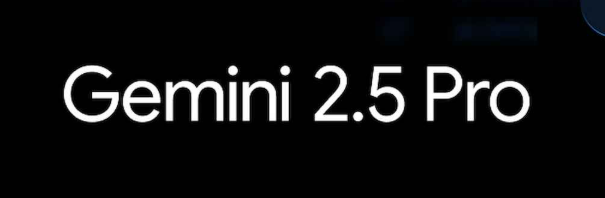


In [1]:
!pip install -U llama-index llama-index-llms-google-genai llama-index-embeddings-google-genai

In [2]:
import os
import nest_asyncio
from google.colab import userdata
from llama_index.core import Settings

# --- Importaciones NUEVAS (Google GenAI) ---
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding

nest_asyncio.apply()

# Obtener API Key
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
except:
    # Si no usas los secretos de Colab, pega tu clave aquí abajo:
    GOOGLE_API_KEY = "TU_CLAVE_AQUI"

# --- Configuración del Modelo (LLM) ---
# Usamos GoogleGenAI en lugar de la clase Gemini antigua.
# IMPORTANTE: Cambié "2.5" a "1.5-pro" porque el 2.5 no existe públicamente aún.
Settings.llm = GoogleGenAI(
    model_name="models/gemini-2.5-pro",
    api_key=GOOGLE_API_KEY,
    temperature=0.1
)

# --- Configuración de Embeddings ---
# Usamos GoogleGenAIEmbedding
Settings.embed_model = GoogleGenAIEmbedding(
    model_name="models/gemini-embedding-001",
    api_key=GOOGLE_API_KEY
)

print("¡Configuración de Google GenAI completada con éxito!")

¡Configuración de Google GenAI completada con éxito!


In [3]:
# 1. Descargar el archivo PDF
!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter

# 2. Cargar el documento
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

# 3. Dividir el texto en "nodos" (chunks de 1024 caracteres)
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

print(f"Documento cargado. Se han creado {len(nodes)} nodos.")

--2026-02-13 22:39:22--  https://openreview.net/pdf?id=VtmBAGCN7o
Resolving openreview.net (openreview.net)... 34.57.44.88
Connecting to openreview.net (openreview.net)|34.57.44.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16911937 (16M) [application/pdf]
Saving to: ‘metagpt.pdf’

metagpt.pdf         100%[===================>]  16.13M  51.3MB/s    in 0.3s    

2026-02-13 22:39:23 (51.3 MB/s) - ‘metagpt.pdf’ saved [16911937/16911937]

Documento cargado. Se han creado 34 nodos.


In [4]:
from llama_index.core import SummaryIndex, VectorStoreIndex

# Importante: Al cambiar el modelo de embeddings, el índice se regenera.
print("Creando índices con el nuevo modelo...")

# Crear índice de resumen
summary_index = SummaryIndex(nodes)

# Crear índice vectorial (Ahora sí debería funcionar)
vector_index = VectorStoreIndex(nodes)

print("¡ÉXITO! Índices creados correctamente.")

Creando índices con el nuevo modelo...
¡ÉXITO! Índices creados correctamente.


In [5]:
from llama_index.core.tools import QueryEngineTool

# 1. Motor de Resumen
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True
)

# 2. Motor Vectorial
vector_query_engine = vector_index.as_query_engine()

# 3. Empaquetar como Herramientas (Tools) con descripciones
summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description="Useful for summarization questions related to MetaGPT"
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description="Useful for retrieving specific context from the MetaGPT paper."
)

print("Herramientas configuradas.")

Herramientas configuradas.


In [6]:
from llama_index.core.query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

# Crear el Router
query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True # Esto nos mostrará en pantalla qué decisión toma el modelo
)

print("Router Query Engine listo para usar.")

Router Query Engine listo para usar.


In [7]:
response = query_engine.query("What is the summary of the document?")
print("\n--- Respuesta ---")
print(str(response))

Selecting query engine 0: The question asks for a summary of the document, and choice 1 explicitly states it is useful for summarization questions..

--- Respuesta ---
MetaGPT is a meta-programming framework that uses Standardized Operating Procedures (SOPs) to enhance problem-solving in multi-agent systems using Large Language Models (LLMs). It assigns specialized roles to agents and uses an assembly line approach to break down complex tasks. The framework incorporates efficient human workflows into LLM-based multi-agent collaborations, allowing agents to verify intermediate results and reduce errors. MetaGPT achieves state-of-the-art performance on software engineering benchmarks by generating coherent solutions and improving code generation quality through an executable feedback mechanism. The framework is designed to be flexible and portable, making it a useful platform for developing LLM-based multi-agent systems.



In [8]:
response = query_engine.query("How do agents share information with other agents?")
print("\n--- Respuesta ---")
print(str(response))

Selecting query engine 1: The question 'How do agents share information with other agents?' requires retrieving specific details about the MetaGPT framework's implementation. Choice (2) is designed for retrieving specific context from the MetaGPT paper, making it the more relevant choice..

--- Respuesta ---
Agents share information through a shared message pool where they can publish structured messages and access messages from other entities. They can also subscribe to relevant information based on their role profiles, allowing them to extract task-related information.



In [9]:
from llama_index.core.tools import FunctionTool
from llama_index.core import Settings

# 1. Definir funciones normales de Python
def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: int, y: int) -> int:
    """Mystery function that operates on top of two numbers."""
    return (x + y) * (x + y)

# 2. Convertirlas en "Herramientas" para la IA
add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

# 3. Probar: Le pedimos a Gemini que use la función "mystery"
# Usamos predict_and_call, que hace que el LLM decida qué función ejecutar y con qué números.
response = Settings.llm.predict_and_call(
    [add_tool, mystery_tool],
    "Tell me the output of the mystery function on 2 and 9",
    verbose=True
)

print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": 2, "y": 9}
=== Function Output ===
121
121


In [10]:
from typing import List
from llama_index.core.vector_stores import FilterCondition, MetadataFilters

# 1. Definir la función de búsqueda con filtros
def vector_query(query: str, page_numbers: List[str]) -> str:
    """
    Perform a vector search over an index, filtering by specific page numbers.

    Args:
        query (str): The string query to be embedded.
        page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to search all pages.
    """

    # Crear los filtros de metadatos basados en los números de página
    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]

    # Configurar el motor de consulta con esos filtros
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )

    # Ejecutar la consulta y devolver la respuesta
    response = query_engine.query(query)
    return str(response)

# 2. Convertir la función en una Herramienta
vector_query_tool = FunctionTool.from_defaults(
    name="vector_tool",
    fn=vector_query
)

print("Herramienta de búsqueda por página creada.")

Herramienta de búsqueda por página creada.


In [11]:
# Gemini debería llamar a vector_query con page_numbers=['2']
response = Settings.llm.predict_and_call(
    [vector_query_tool],
    "What are the high-level results of MetaGPT as described on page 2?",
    verbose=True
)

print("\n--- Respuesta ---")
print(str(response))

# Verificar que realmente usó la página 2 revisando los metadatos (si la respuesta trajo nodos)
# Nota: predict_and_call a veces devuelve solo texto, depende de la versión.

=== Calling Function ===
Calling function: vector_tool with args: {"page_numbers": ["2"], "query": "high-level results of MetaGPT"}
=== Function Output ===
MetaGPT achieves a new state-of-the-art with 85.9% and 87.7% in Pass@1 in code generation benchmarks. It also achieves a 100% task completion rate.


--- Respuesta ---
MetaGPT achieves a new state-of-the-art with 85.9% and 87.7% in Pass@1 in code generation benchmarks. It also achieves a 100% task completion rate.



In [12]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

# 1. Asegurarnos de tener el summary_tool listo (como en la lección 1)
summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True
)

summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description="Useful if you want to get a summary of MetaGPT"
)

# 2. Prueba A: Pregunta Específica con página (Debería usar vector_tool)
print("--- PRUEBA 1: Pregunta específica (Página 8) ---")
response = Settings.llm.predict_and_call(
    [vector_query_tool, summary_tool],
    "What are the MetaGPT comparisons with ChatDev described on page 8?",
    verbose=True
)
print(str(response))

# 3. Prueba B: Pregunta General (Debería usar summary_tool)
print("\n--- PRUEBA 2: Resumen general ---")
response = Settings.llm.predict_and_call(
    [vector_query_tool, summary_tool],
    "What is a summary of the paper?",
    verbose=True
)
print(str(response))

--- PRUEBA 1: Pregunta específica (Página 8) ---
=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT surpasses ChatDev on the SoftwareDev dataset across almost all metrics. It achieves an executability score of 3.75, close to flawless, and requires less time (503 seconds). While MetaGPT uses more tokens (24,613 or 31,255 versus 19,292), it generates one line of code with fewer tokens (126.5/124.3) compared to ChatDev (248.9). Also, MetaGPT demonstrates a lower human revision cost (0.83) compared to ChatDev (2.5).

MetaGPT surpasses ChatDev on the SoftwareDev dataset across almost all metrics. It achieves an executability score of 3.75, close to flawless, and requires less time (503 seconds). While MetaGPT uses more tokens (24,613 or 31,255 versus 19,292), it generates one line of code with fewer tokens (126.5/124.3) compared to ChatDev (248.9). Also, MetaGPT demonstrates a